Este script foi baseado no canal youtube.com/c/canalsandeco

youtube.com/watch?v=qDuVk4HPZ1g

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Funções para seleção dos arquivos do dataset
fator = 0.5
def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    width, height = image.size
    tamanho  = int(width*fator)
    image = image.resize((tamanho,tamanho))#299 , 149
    # convert to array
    return np.asarray(image),tamanho

def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos

    for filename in listdir(diretorio):

        path = diretorio + filename
        try:
            array_image , tamanho = select_image(path)
            imagens.append(array_image)
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels, tamanho

def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + subdir + '/'

        if not isdir(path):
            continue
        imagens, labels,tamanho = load_classes(path, subdir, imagens, labels)

    return imagens, labels,tamanho

In [4]:
#fonte:https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
covid_dataset = "/content/drive/MyDrive/dataset/"
#indexando o dataset
imagens, labels,tamanho  = select_data_set(covid_dataset)
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

In [5]:
tamanho

149

In [6]:
#normalizando as labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
#Variáveis estáticas
batch_size   = 56#32
input_shape  = (tamanho, tamanho, 3)
#random_state = 42
alpha        = 1e-5
epoch        = 100

In [8]:
#tratamento para não ficar preso no mínimo local
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#filepath="/content/drive/MyDrive/best_model/transferlearning_weights.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)
#callbacks = [checkpoint, lr_reduce]
callbacks = [lr_reduce]


In [9]:
#separação do dataset entre treino e teste
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.25, stratify=labels) #, random_state=random_state

In [10]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2)

In [11]:
train_datagen.fit(trainX)

In [12]:
data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

In [13]:
#chamando o vgg19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 149, 149, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 149, 149, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 149, 149, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 74, 74, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 74, 74, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 74, 74, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
#Retreinando a vgg19 a partir da camada ....
camada = 'block5_conv3'
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == camada:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 149, 149, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 149, 149, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 149, 149, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 74, 74, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 74, 74, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 74, 74, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
#configurando o modelo
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [16]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [17]:
history = model.fit(x=data_aug,
                    steps_per_epoch=len(trainX)// batch_size,
                    validation_data=(testX, testY),
                    validation_steps=len(testX) // batch_size,
                    callbacks=callbacks,
                    epochs = epoch)

Epoch 1/100
96/96 [==============================] - 105s 704ms/step - loss: 0.3519 - acc: 0.8556 - val_loss: 1.5429 - val_acc: 0.6167
Epoch 2/100
96/96 [==============================] - 45s 468ms/step - loss: 0.2580 - acc: 0.8914 - val_loss: 0.1979 - val_acc: 0.9463
Epoch 3/100
96/96 [==============================] - 45s 469ms/step - loss: 0.2319 - acc: 0.9061 - val_loss: 0.1591 - val_acc: 0.9353
Epoch 4/100
96/96 [==============================] - 45s 471ms/step - loss: 0.2006 - acc: 0.9242 - val_loss: 0.6899 - val_acc: 0.7417
Epoch 5/100
96/96 [==============================] - 45s 467ms/step - loss: 0.1950 - acc: 0.9260 - val_loss: 0.2532 - val_acc: 0.9038
Epoch 6/100
96/96 [==============================] - 45s 468ms/step - loss: 0.1865 - acc: 0.9264 - val_loss: 0.1474 - val_acc: 0.9419
Epoch 7/100
96/96 [==============================] - 45s 469ms/step - loss: 0.1646 - acc: 0.9357 - val_loss: 0.1289 - val_acc: 0.9580
Epoch 8/100
96/96 [==============================] - 45s 468m

In [19]:
model.save("/content/drive/MyDrive/best_model/transferlearning_weights.hdf5")

In [20]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

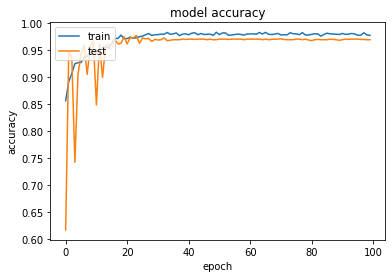

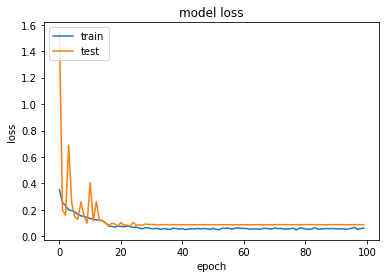

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

Acurácia: 0.9685
Sensitividade: 0.9558
Especificidade: 0.9812


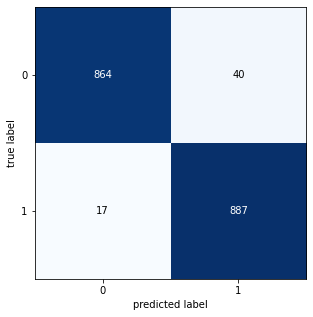

In [23]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()